# **Carga de datos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import zipfile

zip_path = '/content/drive/My Drive/P_Imag_Proyecto/archive.zip'

extract_path = '/content/data'

os.makedirs(extract_path, exist_ok=True)

print(f"Descomprimiendo {zip_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("¡Archivos descomprimidos exitosamente!")

Mounted at /content/drive
Descomprimiendo /content/drive/My Drive/P_Imag_Proyecto/archive.zip...
¡Archivos descomprimidos exitosamente!


# **Preparación de datos!**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns


DATA_DIR = r'C:\Users\USER\Documents\2025-01\ProyectoProcesamientoImagenes\data\chest_xray\chest_xray'
#DRIVE_MODEL_DIR = '/content/drive/My Drive/P_Imag_Proyecto/models'
#MODEL_PATH = os.path.join(DRIVE_MODEL_DIR, 'densenet_neumonia_best.pth')

#os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

IMG_SIZE = 224 #PARA HACER LA IMAGEN 224 x 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
EPOCHS = 30


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
}


image_datasets = {
    x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}


dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=='train'), num_workers=2)
    for x in ['train', 'val', 'test']
}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Tamaños de los datasets: {dataset_sizes}")
print(f"Clases encontradas: {class_names}")

Tamaños de los datasets: {'train': 5216, 'val': 16, 'test': 624}
Clases encontradas: ['NORMAL', 'PNEUMONIA']


# **Visualización!**

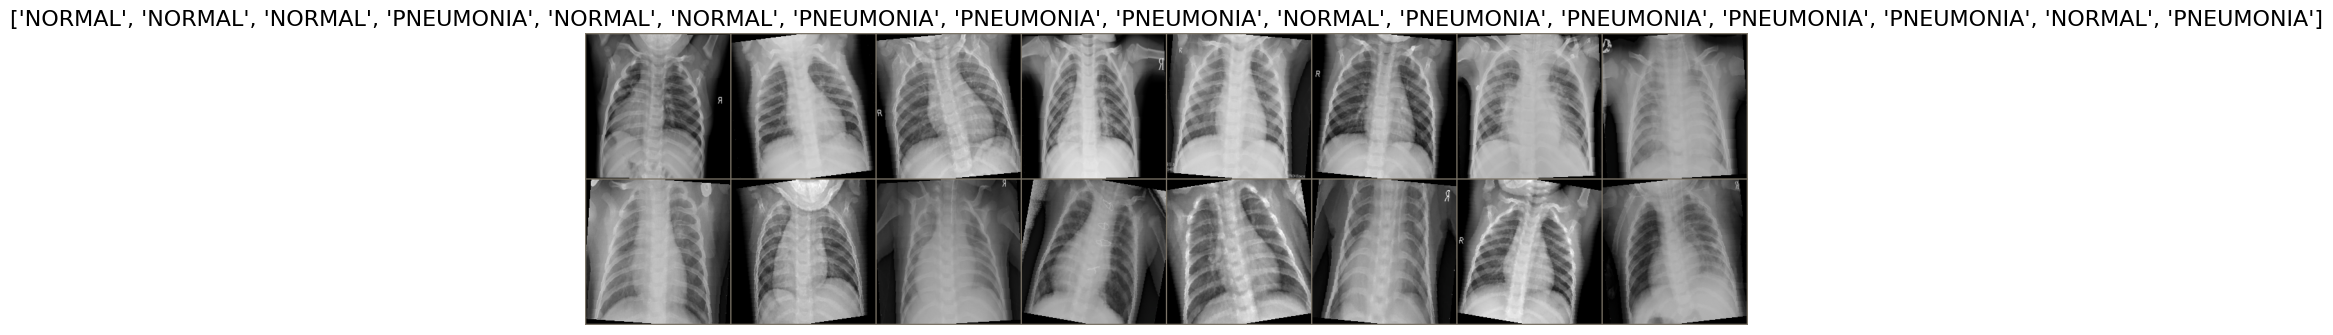

In [10]:
import torchvision
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(15, 10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=16)
    plt.axis('off')
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Se puede evidenciar como hemos hecho ligeras rotaciones dentro de las imagenes para que el modelo pueda aprender bajo pequeños defectos

In [11]:

counts = np.bincount(image_datasets['train'].targets)
count_normal = counts[0] 
count_pneumonia = counts[1]


pos_weight_value = count_normal / count_pneumonia
pos_weight_tensor = torch.tensor([pos_weight_value], device=DEVICE)

print(f"Imágenes de Entrenamiento -> NORMAL: {count_normal}, PNEUMONIA: {count_pneumonia}")
print(f"El 'castigo' por fallar en 'PNEUMONIA' será {pos_weight_value:.2f} veces más grande.")

Imágenes de Entrenamiento -> NORMAL: 1341, PNEUMONIA: 3875
El 'castigo' por fallar en 'PNEUMONIA' será 0.35 veces más grande.


# **Definicion del modelo!**

In [12]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1) #MODELO DENSENET-121

for param in model.features.parameters(): #CONGELAMOS PARÁMETROS DE CAPAS CONVOLUCIONALES, LAS CUALES ESTÁN PRE ENTRENADAS
    param.requires_grad = False

num_ftrs = model.classifier.in_features

model.classifier = nn.Linear(num_ftrs, 1)


model = model.to(DEVICE)

print(model.classifier)

print("\n--- PARÁMETROS A ENTRENAR ---")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Linear(in_features=1024, out_features=1, bias=True)

--- PARÁMETROS A ENTRENAR ---
classifier.weight
classifier.bias


# **Definir Funcion de perdida y Optimizador**

In [13]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor) # USANDO FUNCION DE PERDIDA BCELoss (Binary Cross Entropy Loss)

optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE) #OPTIMIZADOR ADAM

# **Entrenamiento del modelo**

In [14]:
import time
import copy


def train_model(model, criterion, optimizer, num_epochs=30):
    start_time = time.time()


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                labels = labels.float().view(-1, 1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = (torch.sigmoid(outputs) > 0.5).float()
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print()

    time_elapsed = time.time() - start_time
    print(f'Entrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor Acc de Validación: {best_acc:.4f}')

    
    return model, history

# --- Iniciar el entrenamiento ---
print("🚀 Iniciando el entrenamiento...")
model, history = train_model(model, criterion, optimizer, num_epochs=EPOCHS)

🚀 Iniciando el entrenamiento...
Epoch 1/30
----------
Train Loss: 0.3163 Acc: 0.7347
Val Loss: 0.3218 Acc: 0.8125

Epoch 2/30
----------
Train Loss: 0.2476 Acc: 0.8608
Val Loss: 0.2751 Acc: 0.9375

Epoch 3/30
----------
Train Loss: 0.2082 Acc: 0.8871
Val Loss: 0.2376 Acc: 0.9375

Epoch 4/30
----------
Train Loss: 0.1886 Acc: 0.8854
Val Loss: 0.2091 Acc: 0.9375

Epoch 5/30
----------
Train Loss: 0.1697 Acc: 0.8961
Val Loss: 0.2108 Acc: 0.9375

Epoch 6/30
----------
Train Loss: 0.1578 Acc: 0.9036
Val Loss: 0.1811 Acc: 0.9375

Epoch 7/30
----------
Train Loss: 0.1457 Acc: 0.9059
Val Loss: 0.1739 Acc: 0.9375

Epoch 8/30
----------
Train Loss: 0.1380 Acc: 0.9135
Val Loss: 0.1633 Acc: 0.9375

Epoch 9/30
----------
Train Loss: 0.1338 Acc: 0.9103
Val Loss: 0.1584 Acc: 0.9375

Epoch 10/30
----------
Train Loss: 0.1270 Acc: 0.9116
Val Loss: 0.1427 Acc: 0.9375

Epoch 11/30
----------
Train Loss: 0.1259 Acc: 0.9145
Val Loss: 0.1382 Acc: 0.9375

Epoch 12/30
----------
Train Loss: 0.1242 Acc: 0.9080

In [15]:
last_epoch = len(history['train_loss'])
train_loss = history['train_loss'][-1]
train_acc = history['train_acc'][-1]
val_loss = history['val_loss'][-1]
val_acc = history['val_acc'][-1]

print(f"--- Resultados de la Época Final ({last_epoch}/{EPOCHS}) ---")
print(f"Pérdida de Entrenamiento (Train Loss): {train_loss:.4f}")
print(f"Precisión de Entrenamiento (Train Acc): {train_acc:.2%}")
print("-" * 20)
print(f"Pérdida de Validación (Val Loss):   {val_loss:.4f}")
print(f"Precisión de Validación (Val Acc):    {val_acc:.2%}")

--- Resultados de la Época Final (30/30) ---
Pérdida de Entrenamiento (Train Loss): 0.0943
Precisión de Entrenamiento (Train Acc): 92.89%
--------------------
Pérdida de Validación (Val Loss):   0.1168
Precisión de Validación (Val Acc):    93.75%


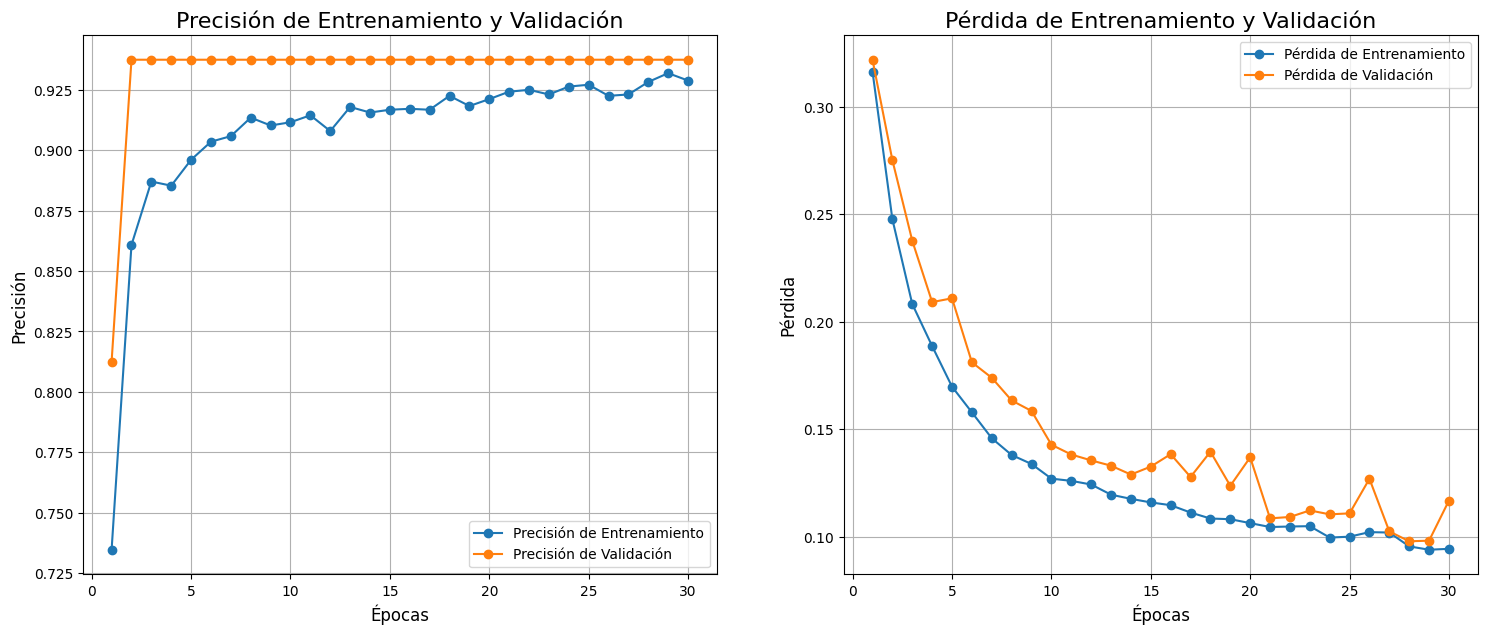

In [16]:

train_acc = history['train_acc']
val_acc = history['val_acc']
train_loss = history['train_loss']
val_loss = history['val_loss']
epochs_range = range(1, EPOCHS + 1)


plt.figure(figsize=(18, 7))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, 'o-', label='Precisión de Entrenamiento')
plt.plot(epochs_range, val_acc, 'o-', label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación', fontsize=16)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, 'o-', label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, 'o-', label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación', fontsize=16)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Pérdida', fontsize=12)
plt.grid(True)

plt.show()

# **Evaluación del modelo**

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

      NORMAL       0.80      0.85      0.82       234
   PNEUMONIA       0.90      0.87      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.86      0.86      0.86       624

AUC-ROC Score: 0.9377


--- Matriz de Confusión ---


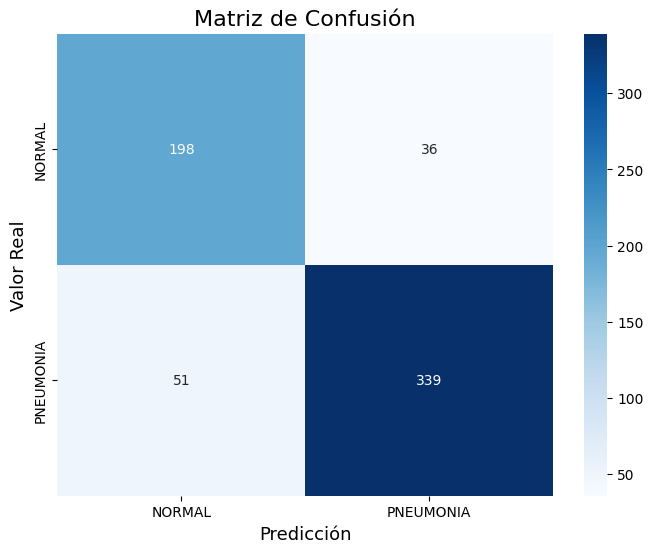

In [17]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)

        y_pred_probs.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
y_pred = np.array(y_pred_probs) > 0.5


print("--- Reporte de Clasificación ---")
print(classification_report(y_true, y_pred, target_names=class_names))


auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"AUC-ROC Score: {auc_score:.4f}")
print("\n")


print("--- Matriz de Confusión ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

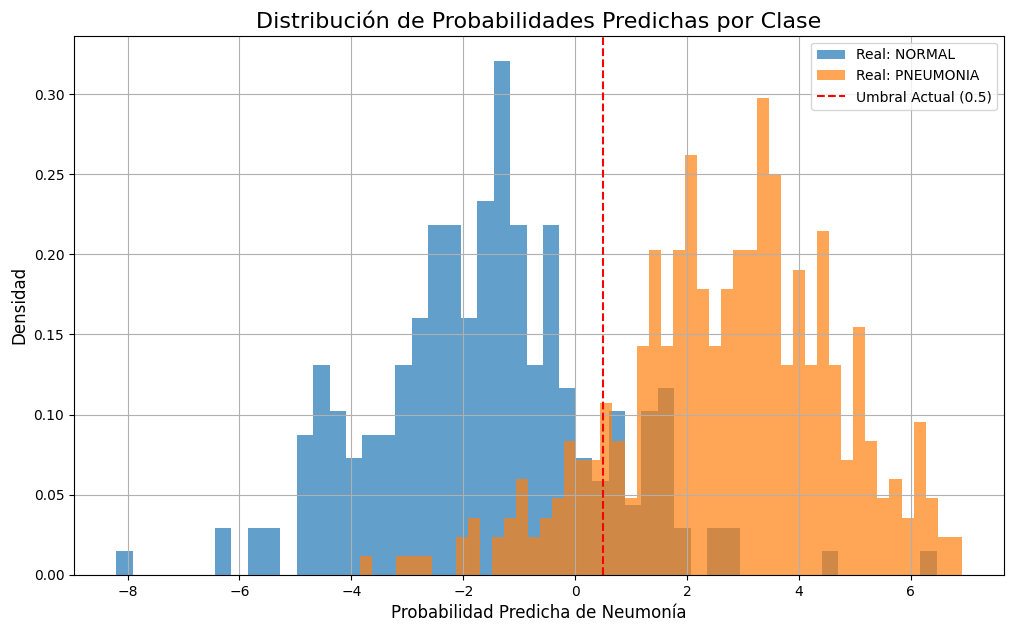

In [18]:
probs_normal = np.array(y_pred_probs)[np.array(y_true) == 0]
probs_pneumonia = np.array(y_pred_probs)[np.array(y_true) == 1]

plt.figure(figsize=(12, 7))
plt.hist(probs_normal, bins=50, label='Real: NORMAL', density=True, alpha=0.7)
plt.hist(probs_pneumonia, bins=50, label='Real: PNEUMONIA', density=True, alpha=0.7)

plt.axvline(0.5, color='red', linestyle='--', label='Umbral Actual (0.5)')

plt.title('Distribución de Probabilidades Predichas por Clase', fontsize=16)
plt.xlabel('Probabilidad Predicha de Neumonía', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



C:\Users\USER\AppData\Local\Temp\ipykernel_20600\1246442284.py:50: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\USER\mi_entorno_ia\Lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


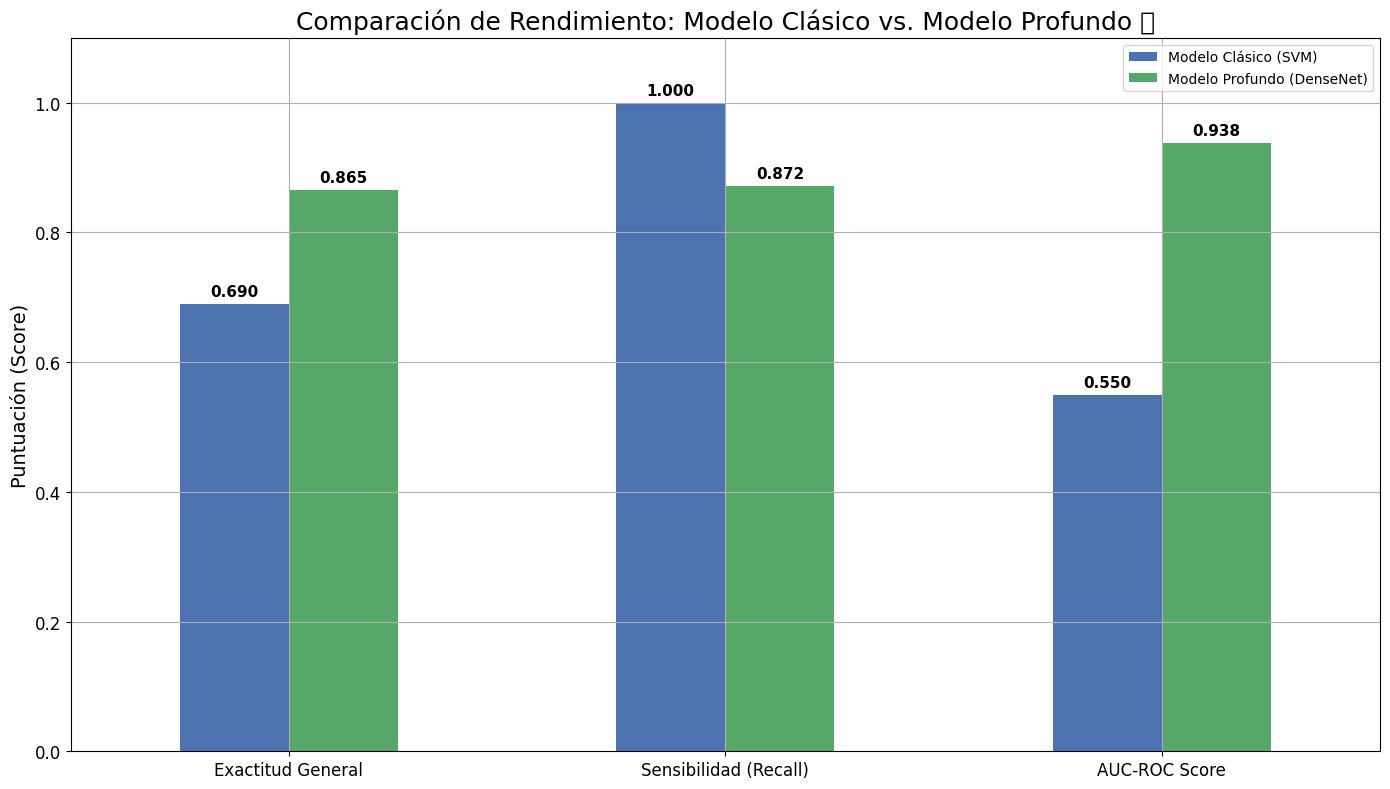

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Creación del Gráfico Comparativo ---

# 1. Definir los datos de la tabla
# NOTA: Los valores del SVM son ilustrativos. Reemplázalos si tienes los números exactos.
data = {
    "Métrica": ["Exactitud General", "Sensibilidad (Recall)", "AUC-ROC Score"],
    "Modelo Clásico (SVM)": [0.69, 1.00, 0.55],
    "Modelo Profundo (DenseNet)": [0.865, 0.872, 0.938] # Usando tus resultados finales
}

# 2. Crear un DataFrame de Pandas
df_compare = pd.DataFrame(data)

# 3. Generar el gráfico de barras agrupado
ax = df_compare.plot(
    x='Métrica',
    kind='bar',
    figsize=(14, 8),
    grid=True,
    legend=True,
    fontsize=12,
    color=['#4C72B0', '#55A868'] # Colores para cada modelo
)

# 4. Añadir títulos y etiquetas
plt.title('Comparación de Rendimiento: Modelo Clásico vs. Modelo Profundo 🏆', fontsize=18)
plt.ylabel('Puntuación (Score)', fontsize=14)
plt.xlabel('') # Quitamos la etiqueta del eje X que es redundante
plt.xticks(rotation=0) # Mantenemos las etiquetas de las métricas horizontales
plt.ylim(0, 1.1) # Damos espacio extra para las etiquetas de datos

# 5. Añadir los valores numéricos encima de cada barra
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}', # Formato con 3 decimales
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=11,
        weight='bold'
    )

# 6. Mostrar el gráfico
plt.tight_layout()
plt.show()